In [1]:
import pandas as pd
import sqlite3 as sql

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# DB file
db_file = '../database/cortona_week.db'

# create a connection
cn = sql.connect(db_file)


In [40]:
query="""
-- Count the participants per conference
WITH tw1 AS 
(
SELECT DISTINCT p.pk_person, e.date conference
FROM Person p 
	LEFT JOIN Participation pp on pp.fk_person = p.pk_person 
	LEFT JOIN Event e on pp.fk_event = e.pk_event 
WHERE e.description = 'Cortona'
--AND e.date BETWEEN 1986 AND 1998
)
SELECT conference, COUNT(*) AS num
FROM tw1
GROUP BY conference
ORDER BY conference;
"""

In [44]:
# Create a cursor
cur = cn.cursor()
cur.execute(query)
# La méthode 'fetchall' permet de récupérer toutes les lignes
r = cur.fetchall()

In [63]:
participants_number = pd.DataFrame(r)
participants_number.columns=['conf', 'number']
participants_number=participants_number.set_index('conf')
participants_number.tail()

,number
conf,
1992,51
1994,39
1995,43
1998,40
2005,45


In [64]:
ly = list(range(1985, 2006))
df_year = pd.DataFrame(ly)
df_year.columns=['conf']
df_year.set_index('conf', inplace=True)
df_year.tail(3)

""
conf
2003
2004
2005


In [69]:
df_conf= df_year.join(participants_number, how='left')
df_conf.reset_index(inplace=True)
df_conf

,conf,number
0,1985,33.0
1,1986,45.0
2,1987,NaN
3,1988,51.0
4,1989,52.0
5,1990,NaN
6,1991,47.0
7,1992,51.0
8,1993,NaN
9,1994,39.0


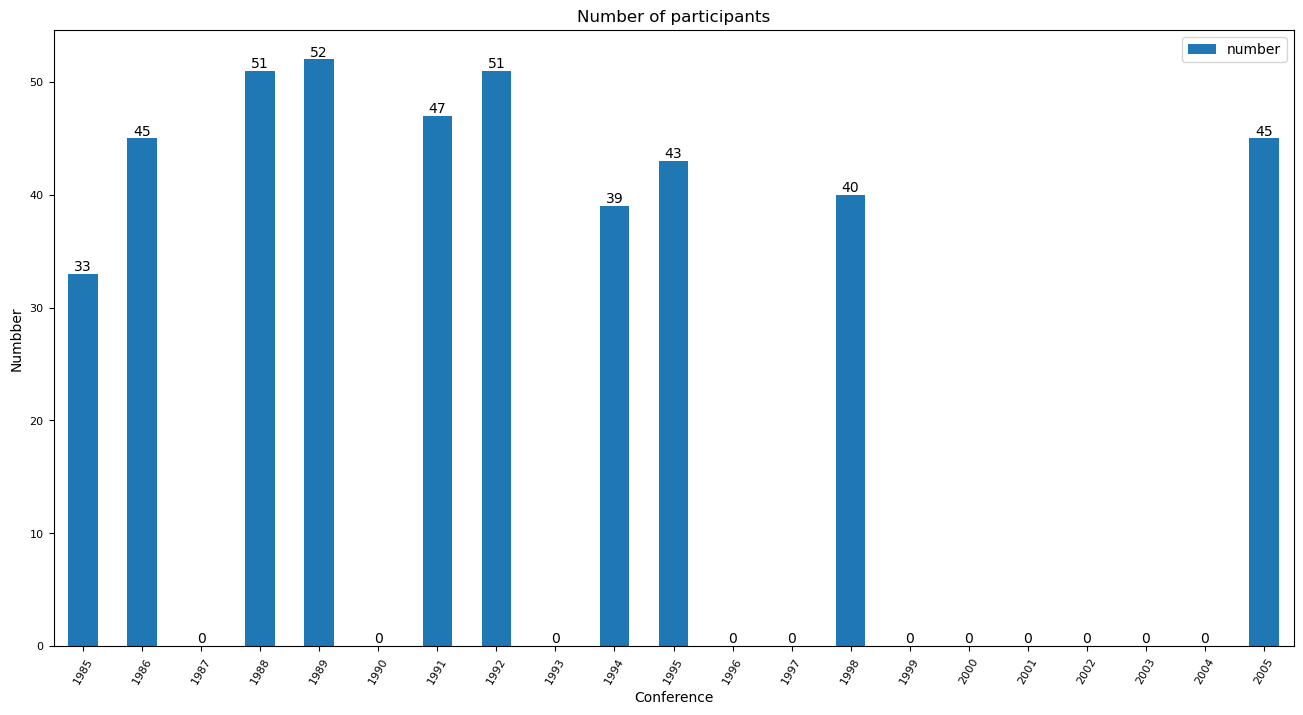

In [73]:
### Représentation graphique des effectifs par année

ax = df_conf.plot(x='conf', y='number', kind='bar',rot=60, fontsize=8, figsize=(16,8))

ax.bar_label(ax.containers[-1])
             
plt.ylabel('Numbber')
plt.xlabel('Conference')
plt.title('Number of participants')
plt.show()

### Genders distribution

In [78]:
query="""
-- Count the participants'gender and conference

SELECT DISTINCT p.pk_person, e.date conference, p.gender
FROM Person p 
	LEFT JOIN Participation pp on pp.fk_person = p.pk_person 
	LEFT JOIN Event e on pp.fk_event = e.pk_event 
WHERE e.description = 'Cortona'
--AND e.date BETWEEN 1986 AND 1998
"""

In [79]:
# Create a cursor
cur = cn.cursor()
cur.execute(query)
# La méthode 'fetchall' permet de récupérer toutes les lignes
r = cur.fetchall()

In [83]:
participants_gender = pd.DataFrame(r)
participants_gender.columns=['id_person', 'conf', 'gender']
participants_gender.tail()

,id_person,conf,gender
441,354,1995,m
442,355,1995,w
443,356,1995,m
444,357,1995,m
445,360,1995,m


In [130]:


### Tableau de contingence
X = "conf"
Y = "gender"  # "0"

ddf = participants_gender[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int).transpose()
ddf = ddf[:-1]
ddf



gender,m,w,Total
conf,,,
1985,25,8,33
1986,30,15,45
1988,39,12,51
1989,33,19,52
1991,32,15,47
1992,32,19,51
1994,25,14,39
1995,27,16,43
1998,23,17,40


In [131]:
ddf['m_p'] = ddf.apply(lambda x : (x.m/x.Total).round(2), axis=1)
ddf['w_p'] = ddf.apply(lambda x : (x.w/x.Total).round(2), axis=1)
ddf

gender,m,w,Total,m_p,w_p
conf,,,,,
1985,25,8,33,0.76,0.24
1986,30,15,45,0.67,0.33
1988,39,12,51,0.76,0.24
1989,33,19,52,0.63,0.37
1991,32,15,47,0.68,0.32
1992,32,19,51,0.63,0.37
1994,25,14,39,0.64,0.36
1995,27,16,43,0.63,0.37
1998,23,17,40,0.57,0.42


In [132]:
lp = ddf['m_p'].to_list()+ddf['w_p'].to_list()
print(lp[:3])

[0.76, 0.67, 0.76]


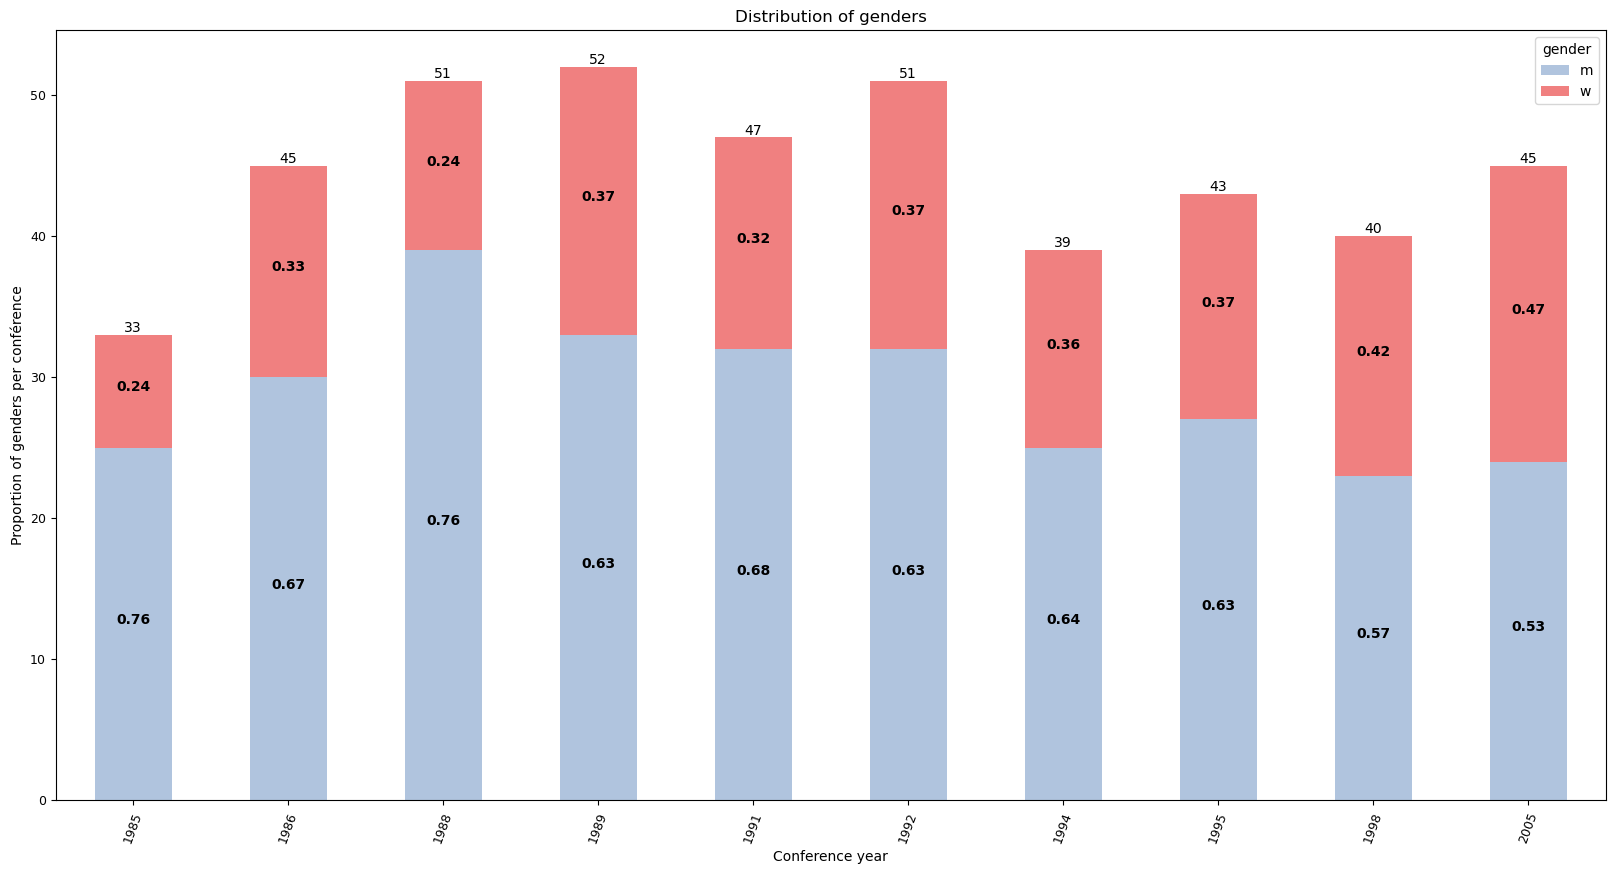

In [135]:
### Graphique avec la distribution par période et genre (M,F)
# Noter que les effectifs du genre 'Autres' étant très faibles,
# on ne les analyse pas de manière sérielle mais on peut les analyser qualitatiement


ax = ddf.plot.bar(stacked=True, y=['m', 'w'], \
                        rot=70, fontsize=9, figsize=(20,10), color=['LightSteelBlue', 'LightCoral'])


### https://www.pythoncharts.com/matplotlib/stacked-bar-charts-labels/


## On ajoute une étiquette concernant la valeur de fréquence
# à chaque rectangle dans le graphe, en utilisant la list 'lp' préparée précédemment
# Il y a autant de triangles que les valeurs d'index x le nombre de variables
for bar,v in zip(ax.patches,lp): 

    ax.text(
      # Met les étiquette aux centre des rectangles
      bar.get_x() + bar.get_width() / 2,
        
      # Ajoute les coordonnées verticales
      bar.get_height()/2 + bar.get_y(), 
      
      # Ajoute les valeurs
      v,

      # centre et met du style aux étiquettes
      ha='center',
      color='black',
      weight='bold',
      size=10
  )


ax.bar_label(ax.containers[-1])


plt.ylabel('Proportion of genders per conférence')
plt.xlabel('Conference year')
plt.title('Distribution of genders')


# Doc.: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html
plt.savefig('images/distribution_conference_gender.jpg', bbox_inches='tight',
                      pad_inches=0.2)
plt.show()